In [56]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob
from functools import reduce

In [57]:
lc_u = np.load('uid_per_shb_fatigue(1).npy')

In [58]:
#np.delete(lc_u[:7], 3)

In [59]:
path = os.getcwd()+'/user_epoch/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df_lcu = []
sex = []
age = []
uid = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    if len(df['phase'].unique()) >= 4 : #and 0 in df['phase'].unique() and 1 in df['phase'].unique()
        if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):
                 
            df_lcu.append(df)
            demo_info = f.split("/")[-1].split('.')[0]
            sex.append(re.split('(\d+)',demo_info)[0])
            age.append(int(re.split('(\d+)',demo_info)[1]))
            uid.append(int(f.split("/")[-1].split('.')[1][1:])) 

In [60]:
dfagg = []
for df in df_lcu:
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    # group by day and hourly - sum up steps and take mean of heart rate
    # per day 24 time bins with steps summed up and mean of heart rate

    #for du in range(len(df_lcu[0])): 
    d = df.copy()
    d['start'] = pd.to_datetime(d['start'])
    d['steps'] = d['steps'].fillna(0)
    d['steps'] = d['steps'] + 1

    df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('30min').mean().reset_index(),d[['start','steps']].set_index('start').resample('30min').sum().reset_index(),how='outer',on='start')
    d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('30min').first().reset_index(),how='outer',on='start')
    dfagg.append(d_agg)

In [61]:
phases = ['pre', 'acute', 'sub-acute', 'post']

In [62]:
colors = ['grey', 'red', 'orange', 'purple']

In [8]:
#for ph in [0,1,2,3]:
#    dph = df[df['phase'] == ph ]
#    plt.scatter(np.log(1 - ((dph['steps'].rank(method='first') - 1)/len(dph['steps'].rank(method='first')))),np.log(dph['steps']),alpha=.3, c= colors[ph])
#plt.legend(phases)
#plt.xlabel('log(rank)')
#plt.ylabel('log(steps)');

In [9]:
#for ph in [0,1,2,3]:
#    dph = df[df['phase'] == ph ]
#    plt.scatter(1 - ((dph['steps'].rank(method='first') - 1)/len(dph['steps'].rank(method='first'))),dph['steps'],alpha=.3,c= colors[ph])
#plt.legend(phases)
#plt.xlabel('rank')
#plt.ylabel('steps');

In [63]:
nranks = []
nsteps = []
for df in dfagg:
    df = df[df['steps'] != 0]
    
    ranks = []
    steps = []
    for ph in [0,1,2,3]:
        
        dph = df[df['phase'] == ph ]
        r = 1 - ((dph['steps'].rank(method='first') - 1)/len(dph['steps'].rank(method='first')))
        ranks.append(r.values)
        steps.append(dph['steps'].values)
    nranks.append(ranks)
    nsteps.append(steps)
         
    

In [64]:
NU = [0,1,3,8,10,18,21,23,29,31,33,38,40,43,44,47]

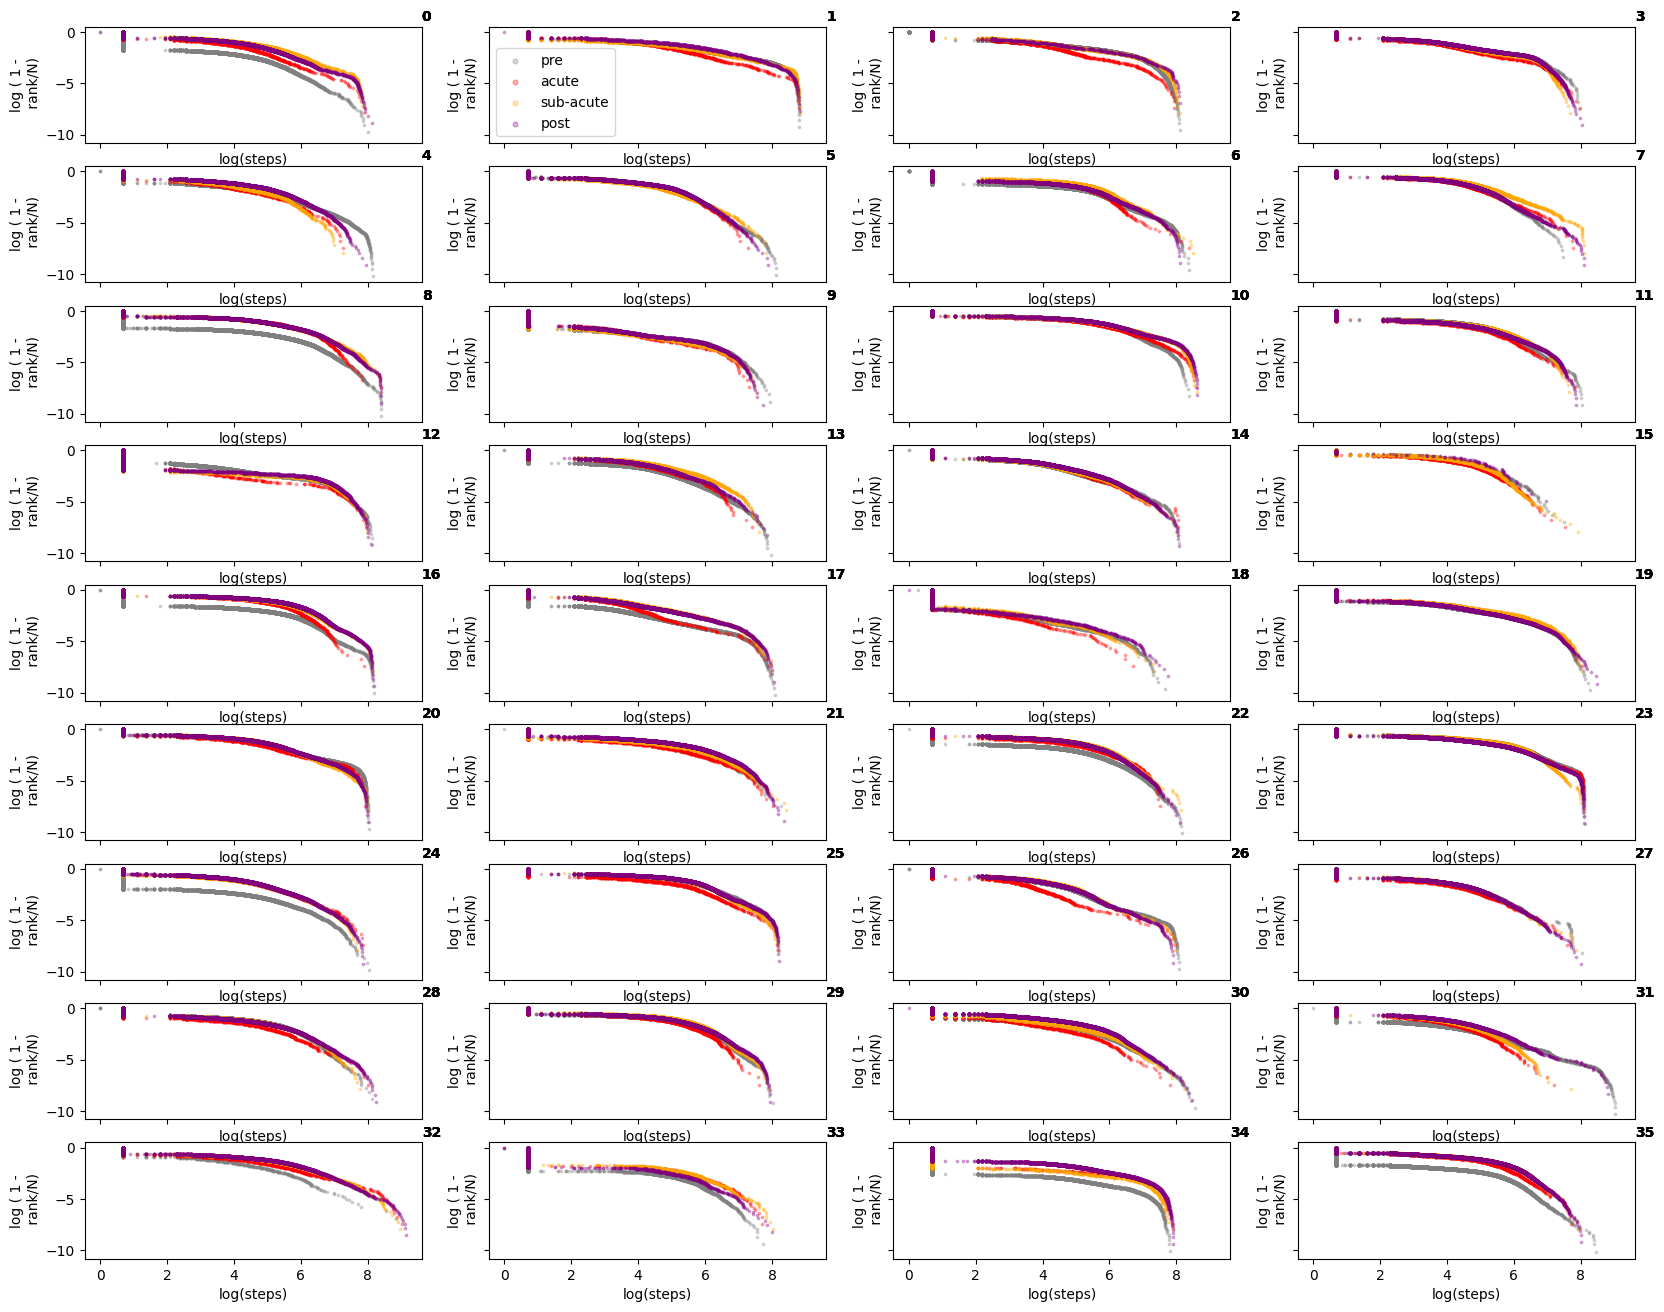

In [66]:
fig, axs = plt.subplots(9,4, figsize=(20, 16
                                      ), facecolor='w', edgecolor='k',sharex=True, sharey = True)
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for d in [i for i in range(len(nranks)) if i not in NU]:
    for ph in [0,1,2,3]:

        
        axs[i].scatter(np.log(nsteps[d][ph]),np.log( nranks[d][ph]),alpha=.3, c= colors[ph],s=3)
        axs[i].set_xlabel('log(steps)')
        axs[i].set_ylabel(r'log ( 1 -'+'\n'+' rank/N)')
        axs[i].text(1, 1.05, str(list(range(len([i for i in range(len(nranks)) if i not in NU])))[i]), transform=axs[i].transAxes, 
            size=10, weight='bold');
    if i == 1:
        axs[i].legend(phases, loc = 'lower left',markerscale=2.)
    i+=1
    
    